# K-means clustering lab

In [177]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

With K-means clustering the goal is to determine class based on clusters of data. The assumption here is that the data is able to be segmented in such a way that the distribution of each class is centered around a certain mean point.

The algorithm works as follows:
1. Choose number K, which signifies the amount of clusters to find.
2. Initialise K centroids (cluster-means) at random
3. Iteratively move the centroids closer to the best value
    - Assign each datapoint to the nearest centroid
    - Recompute the centroid position as the mean of the assigned values from the previous step
4. Repeat until the centroid positions do not change anymore

The main advantage of the Kmeans algorithm is that it is very simple to implement, always converges to a local minimum, scales well to large datasets and generalises well to differently shaped clusters.

Some disadvantages are: K must be selected manually, might not find a global minimum, sensitive to outliers and it may not perform well on datasets with varying density.

Since distance calculations are part of the algorithm, it also dose not scale well with datasets with many features.

## Segmenting Customer Data

In this lab we will use a dataset of mall customer data, where the following features are present:

- Age
- Gender
- Annual Income
- Spending Score

We will use Kmeans to find which features occur together. But first, lets explore the data.

In [178]:
df = pd.read_csv("./data/CustomerData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Below, we graph some of the important points from our data.

- Distribution of Gender (relatively even, though slightly unbalanced)
- Distribution of Annual Income (skewed to the right)
- Scatter plot of Annual Income vs Spending Score (looks like there are 5 domains that can be selected as clusters)

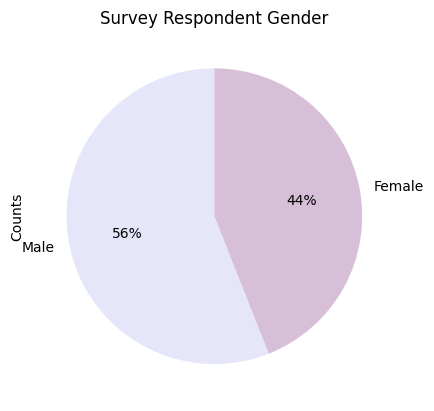

In [179]:
df.value_counts(subset=['Gender']).rename("Counts").plot.pie(
    startangle=90, 
    title="Survey Respondent Gender", 
    autopct='%1.f%%', 
    labels=['Male', 'Female'],
    colors=['lavender', 'thistle']);

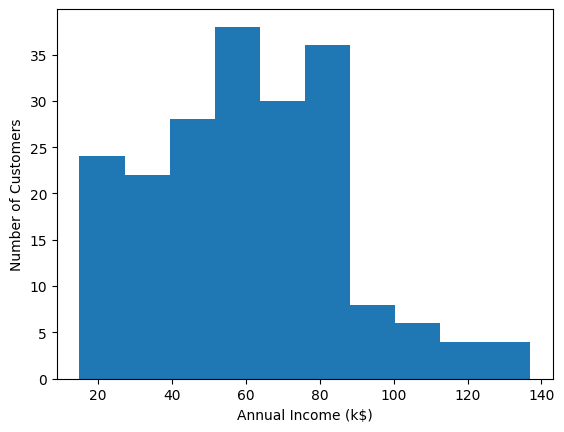

In [180]:
df["Annual Income (k$)"].plot.hist(bins=10, xlabel="Annual Income (k$)", ylabel="Number of Customers");

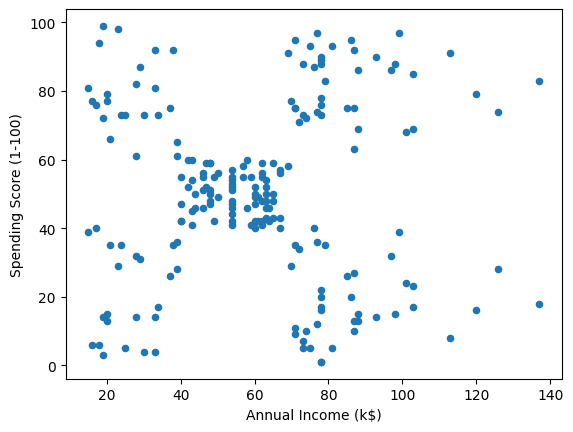

In [181]:
df.plot.scatter(x="Annual Income (k$)", y="Spending Score (1-100)");

Now we will try to cluster these datapoints. From the scatter plot it looks like K=5 will be a good starting point.

## Clustering

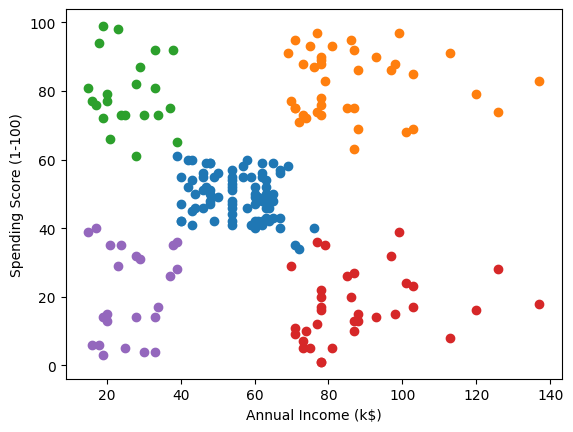

In [182]:
xlabel = 'Annual Income (k$)'
ylabel = 'Spending Score (1-100)'

X = df[[xlabel, ylabel]]

km = KMeans(n_clusters=5, random_state=42).fit(X)

# For each label, grab the datapoints corresponding to that label
for label in np.unique(km.labels_):
    X_ = X[label == km.labels_]
    plt.scatter(X_['Annual Income (k$)'], X_['Spending Score (1-100)'], label=label)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

That definitely looks correct! It seems the KMeans algorithm was able to successfully select the 5 clusters.

## Image Segmentation

Clustering is also a useful algorithm for image segmentation. For example for boundary detestion and object location. The clustering algorithm will group similar pixels together and, depending on the amount of clusters, will make boundaries more pronounced.

((490, 487, 4), dtype('float32'))

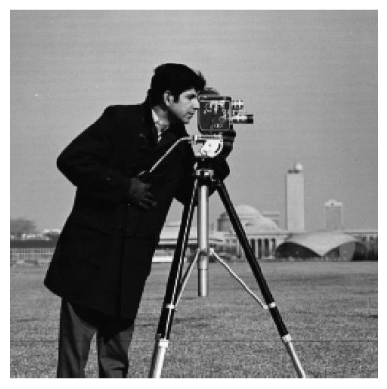

In [183]:
img = plt.imread("./data/cameraman.png")
plt.axis('off')
plt.imshow(img)
img.shape, img.dtype

An image is simpy and M x N array of pixels. These pixels have a specific color, often described by a tuple of 3 or 4 values. In this case the image consists of 490 X 487 pixels with 4 values of colors, encoded as float32 values. We can get more information about the pixel encoding by using Pillow, where we can see that the original image is encoded as 'P', which means single-valued, 8-bit pixels mapping to a color palette (more info [here](https://pillow.readthedocs.io/en/stable/handbook/concepts.html)). So if we use the matplotlib loaded version of the image, we will use much more data than necessary.

This is a pretty interesting deep-dive into how images are encoded, so bear with me.

We have a few options here, since the pixels are encoded as single values indexing palette colors, we could simply cluster these indices. This would work as long as we are not interested in the original colors.

Another option is to cluster the palette instead and convert the image based on the result of that clustering.

We'll try both options here. First, let's open the image using Pillow

In [184]:
from PIL import Image

im = Image.open("./data/cameraman.png")
im.mode, im.size, im.palette.colors.__len__()

('P', (487, 490), 128)

The image is loaded in mode 'P', has 487x490 pixels and a palette of 128 colors.

Let's first cluster the indices, inwhich case we will need to reinterpret the image from palette indexed to actual grayscale. For this we can use the Pillow `convert()` method. In this case we want to convert to 8-bit grascale pixels, or color mode 'L'. This will remove the palette from the image, as it is no longer necessary

In [185]:
im_g = im.convert('L')
im_g.mode, im_g.size, im_g.palette

('L', (487, 490), None)

Then we can use the clustering as before, by reshaping the image into an array of datapoints and fitting a `KMeans` instance.

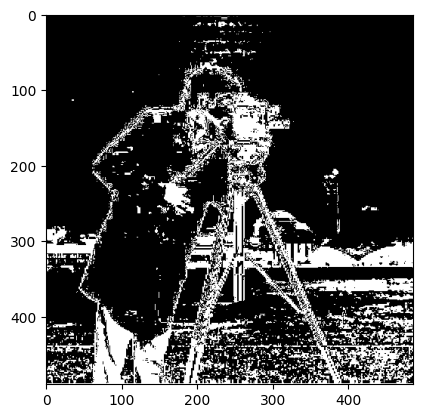

In [186]:
k = 2

# We reinterpret each pixel as a datapoint 
X = np.array(im).reshape(-1, 1)
km_im = KMeans(n_clusters=k, random_state=42)
labels = km_im.fit_predict(X)
# Here we replace the palette indices with the found palette index values
# Since this is not the same as a color, the resulting image looks weird.
plt.imshow(km_im.cluster_centers_[labels].reshape(np.array(im).shape), cmap='grey');

The resulting image, plotted directly, looks a bit weird. This is because the indices are not necessarily logically related to the colors, so interpreting them as colors is often incorrect. Below we recover the actual colors, but first we need to learn some more about the palette fitting.

Alternatively, we can cluster the palette instead. Since the palette only has 128 entries, this is much faster than the entire 487x490 image. The `getpalette()` function returns the palette as a flattened list, so we need to reshape it into (-1, 3) to recover the actual pixels

In [187]:
palette = np.array(im.getpalette()).reshape(-1, 3)
palette.shape

(128, 3)

Now we can simply run the clustering on the palette instead, only having to deal with $\frac{128*3}{487*490}=\frac{384}{238630}=0.16\%$ of the original image size.

In [188]:
km_p = KMeans(n_clusters=2, random_state=42)
labels = km_p.fit_predict(palette)
labels

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

No we have assigned each palette entry to a cluster, which we can use to reindex the original image.

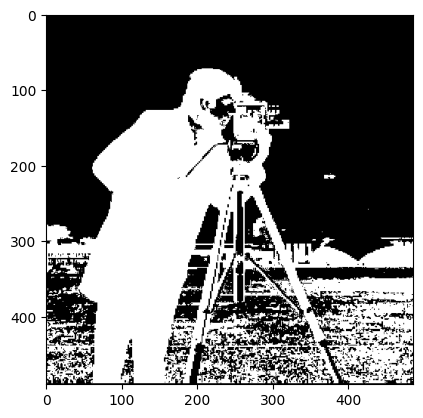

In [189]:
indexed_pixels = np.array(im)
clustered_pixels = labels[indexed_pixels]
plt.imshow(clustered_pixels, cmap='grey');

Since the initialisation of the algorith is random, in this case the results are inverted. We used the same initial random state, but used different types of data to cluster on. Changing the random state will change the order of clusters.

Both methods also allow the plotting of the image using the color centers of the found centroids.

The palette-fitted method is easy, we simply use the clustered image and assign the centroid values based on label.

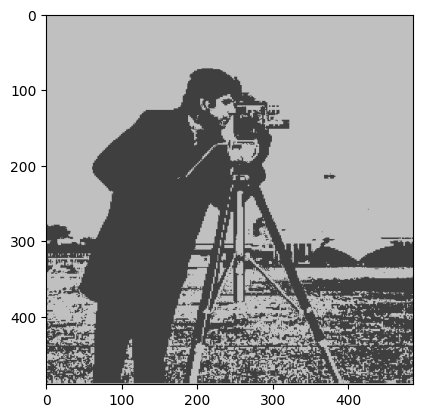

In [190]:
# Take the found centroids
centroids_p = km_p.cluster_centers_.astype(np.uint8)
# Index the centroids based on the assigned labels
segmented_p_rgb = centroids_p[clustered_pixels]
plt.imshow(segmented_p_rgb);

The earlier case is a bit more complex. One issue that arises is that the found centroids are very unlikely to be valid palette indices since palette indices are integers and the found centroids are floats. So we will have to round to the nearest valid palette index. This introduces inaccuracies.

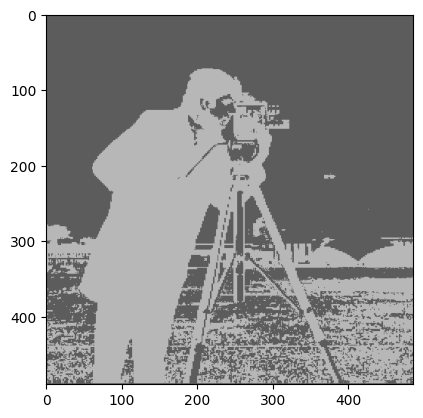

In [192]:
centroids_im = km_im.cluster_centers_.astype(np.uint8)
centroids_as_palette_color = palette[centroids_im]
plt.imshow(centroids_as_palette_color[clustered_pixels].squeeze(2));

## Exercise

Let's do this again, but with another image. Now we have an actual RGB image, so we have to perform the clustering on the pixel values directly.

In [231]:
im_kf = Image.open("./data/kingfisher.jpeg")
h, w = im_kf.height, im_kf.width
n = 3
im_kf.size, im_kf.mode

((640, 426), 'RGB')

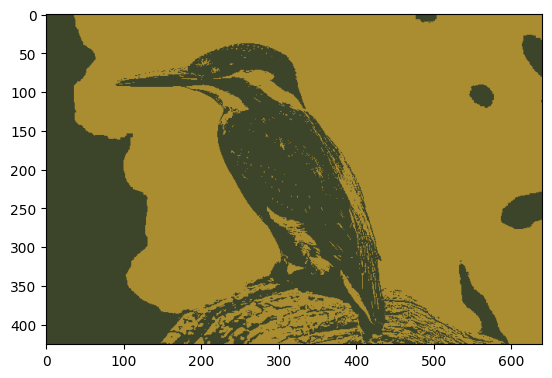

In [232]:
K = 2

X = np.array(im_kf).reshape(-1, n)

km_kf = KMeans(n_clusters=K, random_state=42).fit(X)
labels = km_kf.predict(X)
centroids = km_kf.cluster_centers_.astype(np.uint8)

plt.imshow(centroids[labels].reshape(h, w, n))

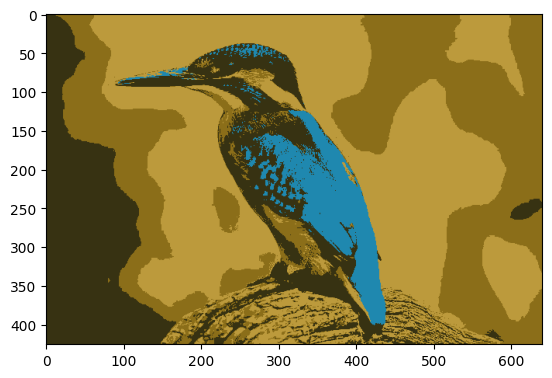

In [233]:
K = 4

X = np.array(im_kf).reshape(-1, n)

km_kf = KMeans(n_clusters=K, random_state=42).fit(X)
labels = km_kf.predict(X)
centroids = km_kf.cluster_centers_.astype(np.uint8)

plt.imshow(centroids[labels].reshape(h, w, n))

## Decision boundary in color space

Now we can see the effect of the clustering on the original image, but it would also be nice to see what the actual algorithm is doing. For this we can plot the decision boundary in color space. First of all, this is easiest when shown in 2D for a specific slice of color space. Below we start with showing the boundary at B=128.

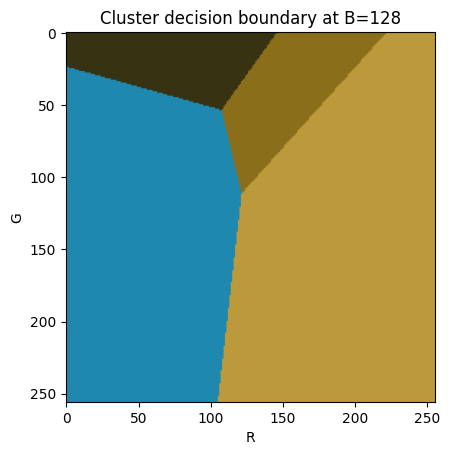

In [235]:
def assign_cluster(c):
    dists = np.linalg.norm(centroids - c, axis=1)
    return np.argmin(dists)

# Build a grid of RGB color values
R, G = np.meshgrid(np.arange(256), np.arange(256))
B = 128
grid = np.stack([R, G, np.full_like(R, B)], axis=-1).reshape(-1, 3)

# 
grid_labels = np.argmin(np.linalg.norm(grid[:, None] - centroids[None, :], axis=2), axis=1)
# Get the color of each section
grid_colors = centroids[grid_labels]
grid_colors_image = grid_colors.reshape(R.shape[0], R.shape[1], 3)

plt.imshow(grid_colors_image)
plt.xlabel("R")
plt.ylabel("G")
plt.title(f"Cluster decision boundary at B={B}")
plt.show()

In [244]:
# Example centroids from KMeans
centroids = km_kf.cluster_centers_.astype(np.uint8)

# Downsample RGB space to keep memory manageable
step = 16  # adjust for finer resolution
R, G, B = np.meshgrid(
    np.arange(0, 256, step),
    np.arange(0, 256, step),
    np.arange(0, 256, step)
)
grid = np.stack([R, G, B], axis=-1).reshape(-1, 3)

dists = np.linalg.norm(grid[:, None] - centroids[None, :], axis=2)
labels = np.argmin(dists, axis=1)
colors = centroids[labels]  # each point gets its centroid color

import plotly.graph_objects as go

# Reshape back to 3D volume for slicing
shape = R.shape
colors_volume = colors.reshape(*shape, 3)

# Flatten for scatter3d
x, y, z = R.flatten(), G.flatten(), B.flatten()
rgb_colors = ['rgb({},{},{})'.format(*c) for c in colors]

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=4, color=rgb_colors),
)])
fig.update_layout(
    scene=dict(
        xaxis_title='R', yaxis_title='G', zaxis_title='B'
    ),
    width=400, height=400
)
fig.show()


In [246]:
import numpy as np
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from PIL import Image

# -------------------------------
# Load image and fit KMeans
# -------------------------------
im_kf = Image.open("./data/kingfisher.jpeg")
X = np.array(im_kf).reshape(-1, 3)

k = 4
km = KMeans(n_clusters=k, random_state=42).fit(X)
centroids = km.cluster_centers_.astype(np.uint8)
labels = km.predict(X)

# -------------------------------
# Build downsampled RGB grid
# -------------------------------
step = 16  # adjust for finer resolution
R, G, B = np.meshgrid(
    np.arange(0, 256, step),
    np.arange(0, 256, step),
    np.arange(0, 256, step)
)
grid = np.stack([R, G, B], axis=-1).reshape(-1, 3)

# Assign each grid point to nearest centroid
dists = np.linalg.norm(grid[:, None] - centroids[None, :], axis=2)
grid_labels = np.argmin(dists, axis=1)
grid_colors = centroids[grid_labels]

# Flatten for plotting
x, y, z = grid[:, 0], grid[:, 1], grid[:, 2]
rgb_colors = ['rgb({},{},{})'.format(*c) for c in grid_colors]

# -------------------------------
# Create figure with slices along an axis
# -------------------------------
axis = 'B'  # choose 'R', 'G', or 'B'
axis_idx = {'R':0, 'G':1, 'B':2}[axis]

# Get unique slice values
slice_values = np.unique(grid[:, axis_idx])

# Build a trace for each slice
traces = []
for v in slice_values:
    mask = grid[:, axis_idx] == v
    trace = go.Scatter3d(
        x=x[mask], y=y[mask], z=z[mask],
        mode='markers',
        marker=dict(size=4, color=np.array(rgb_colors)[mask]),
        visible=False,
        name=f"{axis}={v}"
    )
    traces.append(trace)

# Make first slice visible
traces[0].visible = True

# -------------------------------
# Add slider
# -------------------------------
steps = []
for i, val in enumerate(slice_values):
    step = dict(
        method="update",
        args=[{"visible": [j==i for j in range(len(traces))]}],
        label=str(val)
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": f"{axis} slice: "},
    pad={"t": 50},
    steps=steps
)]

fig = go.Figure(data=traces)
fig.update_layout(
    width=800,
    height=800,
    scene=dict(
        xaxis_title='R', yaxis_title='G', zaxis_title='B'
    ),
    sliders=sliders,
    title="RGB Color-Space Clustering with Slice Slider"
)

fig.show()
